In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023



torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



load = pd.read_csv("./processed_data/RISE_2021_load.csv", index_col = 0)
# X: 210101-211230, Y: 210102-211231 / 364*25 (24h+1flag)
X = load.iloc[0:364,0:24]
Y = load.iloc[1:365,0:24]
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)


dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()


# dataset seperation
train_size = int(data_len * 0.8)
mini_train_size = int(train_size * 0.8)


# train_data, valid_data, validation_data, test_data
# 고민: data split 과정에서 randomness를 부가해야 할까?
# ==> training data에만 shuffle, 이외 validataion, testing에서는 shuffle 없음. 즉, random_split도 사용하지 않음.
train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 291개   210101 ~ 211018
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 73개    211019 ~ 211230
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 232개   210101 ~ 210820
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 59개    210821 ~ 211018

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

[Text(0, 0, '1'),
 Text(31, 0, '2'),
 Text(59, 0, '3'),
 Text(90, 0, '4'),
 Text(120, 0, '5'),
 Text(151, 0, '6'),
 Text(181, 0, '7'),
 Text(212, 0, '8'),
 Text(243, 0, '9'),
 Text(273, 0, '10'),
 Text(304, 0, '11'),
 Text(334, 0, '12')]

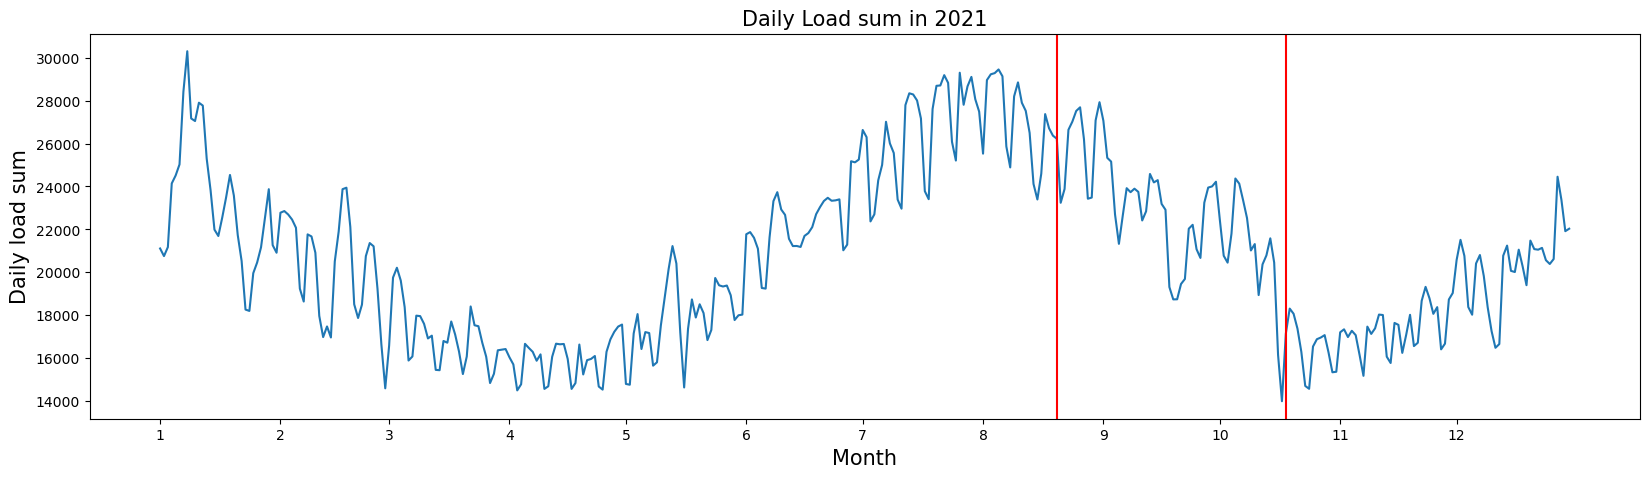

In [4]:
label_interval = [31,28,31,30,31,30,31,31,30,31,30,31] # 2021년 월별 일자 수
# data = X.detach().numpy().reshape(-1)                      # version 1: 데이터를 변형하지 않고 그대로 나타낸다. 1 row당 24 columns가 있으니 reshape 처리하면 하루가 24개의 데이터로 이루어지게 된다.
data = torch.sum(X, axis=1).detach().numpy().reshape(-1)     # version 2: 데이터를 변형한다. 하루의 load를 합계하여 그래프를 더 보기 좋게 만든다.

# Create figure and plot the data
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax.plot(data)

plt.title('Daily Load sum in 2021', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Daily load sum', fontsize = 15)

# Set the x-tick positions and labels
x_ticks = []
x_labels = []
for i, interval in enumerate(label_interval):
    # start = sum(label_interval[:i])*24       # 하루에 24개의 feature가 있으니까 24를 따로 곱해주었다.
    start = sum(label_interval[:i])            # X를 그대로 사용하지 않고, 일자별로 load 합계를 구했기 때문에 feature 개수인 24를 곱하지 않는다.
    x_ticks.append(start)
    x_labels.append(f'{i+1}')

plt.axvline(x = 231, c='r')
plt.axvline(x = 290, c='r')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)


In [6]:
# # min max 날짜 찾아내는 코드 -->  근데 쓸모없게 됨..
# print(torch.max(torch.sum(X, axis=1)), torch.min(torch.sum(X, axis=1)), torch.max(torch.sum(X, axis=1))-torch.min(torch.sum(X, axis=1)))
# def findDate(value):
#     for i in range(0,24):
#         for e in load['{}'.format(i)]:
#             if e == value:
#                 print(i)
#                 return i

# # 활용 예시
# print(torch.max(X), torch.min(X))  # X, Y 모두 max, min 차이가 같다.
# value = 33337.7969    
# load.loc[load['{}'.format(findDate(value))] == value]

In [5]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(train_dataloader.dataset)/24).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(24, 256)
#         self.fc2 = nn.Linear(256, 1024)
#         # self.fc3 = nn.Linear(1024, 128)
#         self.fc4 = nn.Linear(1024, 24)
#         self.relu = nn.ReLU()
#         self.batch_norm1 = nn.BatchNorm1d(256)
#         self.batch_norm2 = nn.BatchNorm1d(1024)
#         # self.sig = nn.Sigmoid()
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.batch_norm1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.batch_norm2(x)
#         x = self.relu(x)
#         # x = self.fc3(x)
#         # x = self.relu(x)
#         output = self.fc4(x)
#         return output
    

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(24, 64)
        self.fc2 = nn.Linear(64, 512)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(512, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(512)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output
    

In [7]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 5000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
criterion2 = nn.MSELoss(reduction = 'mean').to(DEVICE)
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0


for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion2(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
    if epoch % 500 == 0:
        print(f'Train Epoch: {epoch:4d}/{EPOCHS}  |  Train Loss {mini_train_loss:.6f}  |  Val Loss {val_loss:.6f}')



print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/5000  |  Train Loss 786454.187500  |  Val Loss 832093.375000
Train Epoch:  200/5000  |  Train Loss 6204.084473  |  Val Loss 6175.389648
Train Epoch:  400/5000  |  Train Loss 5092.890137  |  Val Loss 5573.476074
Train Epoch:  600/5000  |  Train Loss 4723.669434  |  Val Loss 5390.618164
Train Epoch:  800/5000  |  Train Loss 4664.623535  |  Val Loss 5315.304199
Train Epoch: 1000/5000  |  Train Loss 4634.373535  |  Val Loss 5160.346191
Train Epoch: 1200/5000  |  Train Loss 4415.404297  |  Val Loss 5097.044922
Train Epoch: 1400/5000  |  Train Loss 4359.061523  |  Val Loss 5111.867676
Train Epoch: 1600/5000  |  Train Loss 4289.011230  |  Val Loss 5014.517578
Train Epoch: 1800/5000  |  Train Loss 4293.153809  |  Val Loss 4942.777832
Train Epoch: 2000/5000  |  Train Loss 4192.631348  |  Val Loss 4976.250000
Train Epoch: 2200/5000  |  Train Loss 4122.277832  |  Val Loss 4981.464844
Train Epoch: 2400/5000  |  Train Loss 4195.635742  |  Val Loss 4884.654297
Train Epoch: 2600/500

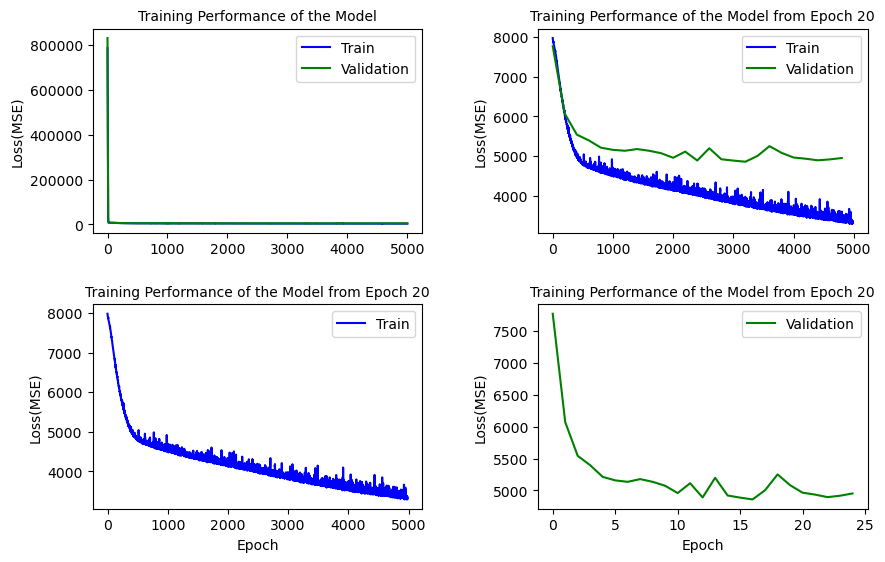

In [12]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.plot(np.arange(0, 5000, 200), val_loss_arr[20::200], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[20::200], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

In [9]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()


for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}'.format(
            epoch, best_val_epoch, train_loss))

test_output, test_y = evaluate(model, test_dataloader)

test_mse = criterion2(test_output, test_y)
test_mae = mae(test_output, test_y)
test_mape = mape(test_output, test_y)


print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
print('MAPE(%): {:.6f}'.format(test_mape*100))

Train Epoch:    0/3265  |  Train Loss 3718.702393
Train Epoch:  200/3265  |  Train Loss 3580.023193
Train Epoch:  400/3265  |  Train Loss 3571.735352
Train Epoch:  600/3265  |  Train Loss 3537.972412
Train Epoch:  800/3265  |  Train Loss 3457.847900
Train Epoch: 1000/3265  |  Train Loss 3411.841797
Train Epoch: 1200/3265  |  Train Loss 3398.485596
Train Epoch: 1400/3265  |  Train Loss 3280.140625
Train Epoch: 1600/3265  |  Train Loss 3403.608643
Train Epoch: 1800/3265  |  Train Loss 3341.661377
Train Epoch: 2000/3265  |  Train Loss 3178.379883
Train Epoch: 2200/3265  |  Train Loss 3107.218994
Train Epoch: 2400/3265  |  Train Loss 3081.798096
Train Epoch: 2600/3265  |  Train Loss 3179.485596
Train Epoch: 2800/3265  |  Train Loss 3028.048096
Train Epoch: 3000/3265  |  Train Loss 2897.422119
Train Epoch: 3200/3265  |  Train Loss 2883.648682
Test Loss
MSE: 5222.371582
MAE: 50.664215
MAPE(%): 6.474152


In [16]:
def plot(i, length, output, Y):
    fig = plt.figure(figsize=(20, 5))
    plt.title('Actual and forecast load for 20 days', fontsize = 18)
    plt.xlabel('Time (h)', fontsize = 15)
    plt.ylabel('Load', fontsize = 15)
    plt.plot(Y.detach().numpy()[i:i+length,:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+length,:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)


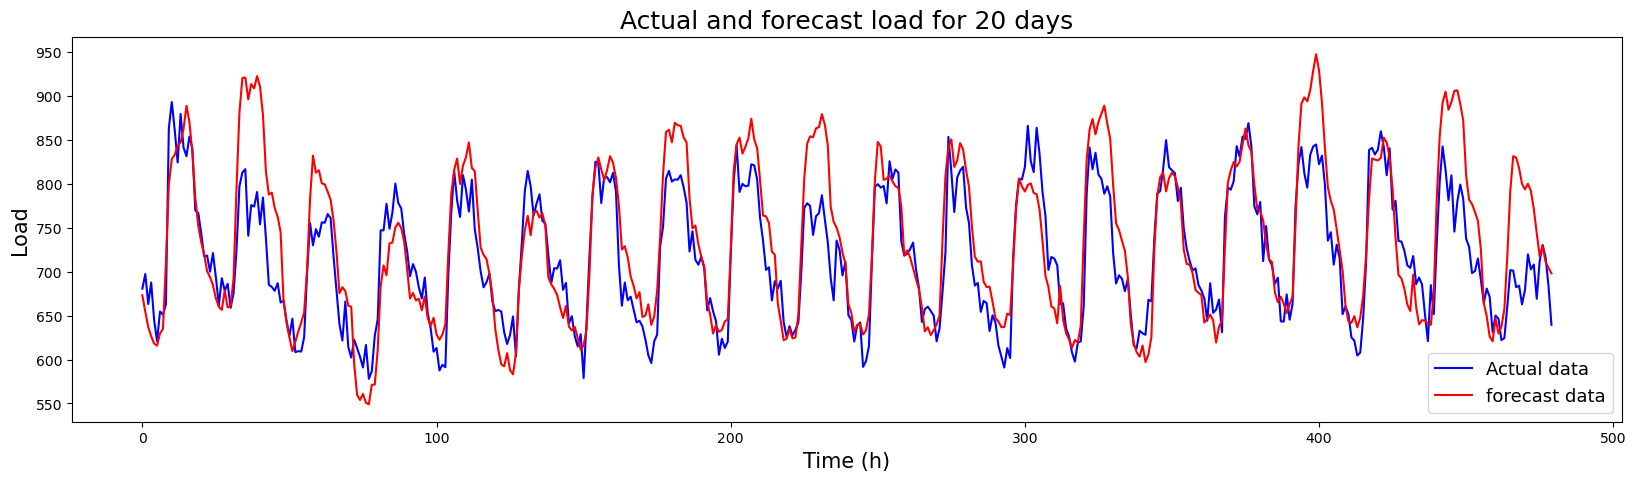

In [17]:
# 211019 ~ 211116
plot(1, 20, test_output, test_y)

In [18]:
torch.save(model.state_dict(), './model_pt/model_512.pt')

In [19]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()

model = Net().to(DEVICE)

EPOCHS = 5000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss(reduction="sum")
mini_train_loss_arr = []
val_loss_arr = []


model.load_state_dict(torch.load(f'./model_pt/model_512.pt'))
test_output, test_y = evaluate(model, test_dataloader)

test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
test_mape = mape(test_output, test_y)


print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
print('MAPE(%): {:.6f}'.format(test_mape*100))

Test Loss
MSE: 4556304.500000
MAE: 47.828671
MAPE(%): 5.921666


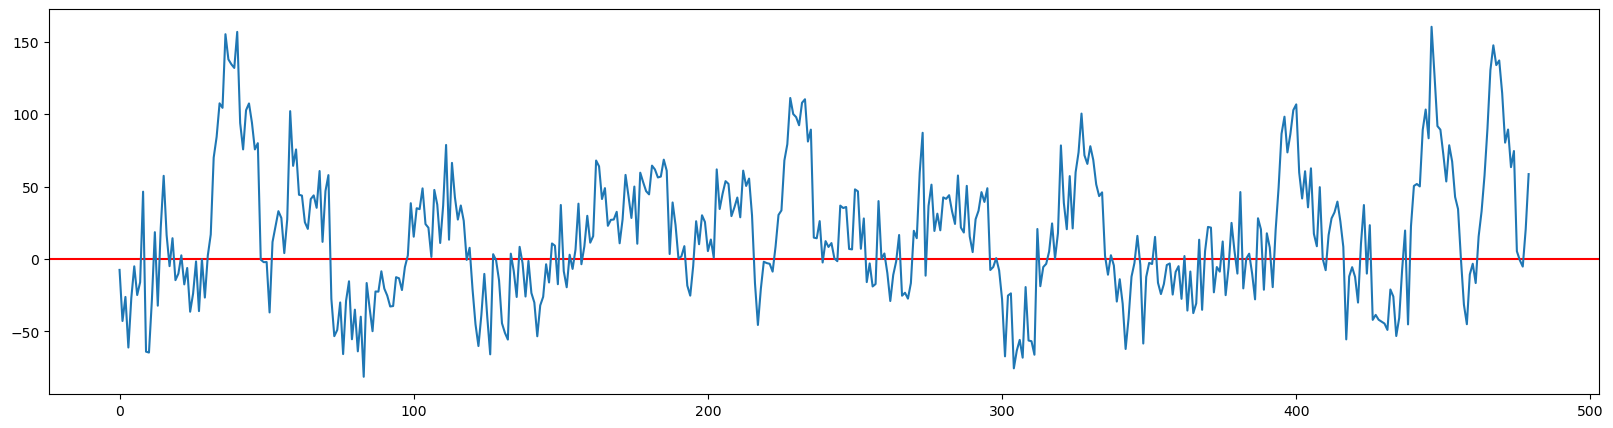

In [20]:
diff=(test_output-test_y)

plt.figure(figsize=(20,5))
plt.axhline(y=0, c='r')
plt.plot(diff.detach().numpy()[1:21].reshape(-1))
